In [1]:
cd(@__DIR__)
using Pkg
Pkg.activate(".")

# using Plots
using Optim
using LinearAlgebra
using Random
using Distributions
using GLMakie
Makie.inline!(true)

  Activating new project at `c:\Documents\Project\metadynamics`


true

## Define basic functions

In [2]:
function meshgrid(x, y)
    ny, nx = length(y), length(x)
    rx = repeat(reshape(x, 1, nx), ny, 1)
    ry = repeat(reshape(y, ny, 1), 1, nx)
    return rx, ry
end

function elementwise_f(f, X, Y)
    # return map(x->f(x), zip(X,Y))
    # Check if X and Y have the same dimensions
    if size(X) != size(Y)
        error("Input arrays X and Y must have the same dimensions.")
    end

    # Initialize the output array Z with zeros
    Z = zeros(size(X))

    # Apply f(x, y) element-wise and store in Z
    for i = 1:size(X, 1)
        for j = 1:size(X, 2)
            x = X[i, j]
            y = Y[i, j]
            z = f([x, y])
            Z[i, j] = z
        end
    end

    # Return the result

    # Z = map(x->f(x), zip(X,Y))
    return Z
end

elementwise_f (generic function with 1 method)

## Define potential and penalty functions

In [3]:
# A simple PES function
function f_basin(x)
    coord = [x..., 0.0]
    rho_basin = 0.24 * sum((coord - [0.0, 0.0, 0.0]).^4)
    return rho_basin
end

function f_z(x)
    return sin.(frequency * x[1]) .* cos.(frequency * x[2]) + f_basin(x)
end

# Penalty function
function f_phi_p(x, x_0, sigma=0.01, W=0.5)
    phi_p = sum([W * exp(-sum((x .- c).^2) / (2*sigma^2)) for c in x_0])
    return phi_p
end

f_phi_p (generic function with 3 methods)

## Construct PES on gridspace

In [4]:
n_grid::Int = 480
x = range(-1.2, stop=1.2, length=n_grid+1)
y = range(-1.2, stop=1.2, length=n_grid+1)

# Create 2D meshgrid
X, Y = meshgrid(x, y)

# Compute Z as a function of X and Y
# Define a common frequency for the landscape
frequency = 2 * π * 1


# Compute Z as a function of X and Y using the common frequency
# Z = elementwise_f(f_z, X, Y) + elementwise_f(f_basin, X, Y)
Z = map(x->f_z(x)+f_basin(x), zip(X, Y))

481×481 Matrix{Float64}:
 1.69676  1.68342  1.67057  1.65821  …  2.22542  2.24521  2.26492  2.28455
 1.65201  1.63897  1.62645  1.61445     2.23621  2.25636  2.2764   2.29633
 1.60778  1.59504  1.58285  1.5712      2.2469   2.2674   2.28777  2.308
 1.5641   1.55166  1.53979  1.52849     2.25746  2.27831  2.299    2.31953
 1.521    1.50885  1.4973   1.48634     2.26786  2.28906  2.31006  2.33088
 1.4785   1.46663  1.45539  1.44478  …  2.27808  2.29961  2.32093  2.34204
 1.43662  1.42504  1.41411  1.40382     2.28808  2.30995  2.33158  2.35297
 1.39539  1.38408  1.37346  1.3635      2.29785  2.32005  2.34198  2.36364
 1.35483  1.3438   1.33347  1.32384     2.30735  2.32987  2.3521   2.37404
 1.31497  1.30421  1.29417  1.28485     2.31656  2.33939  2.36191  2.38412
 ⋮                                   ⋱                             ⋮
 1.35483  1.3438   1.33347  1.32384     2.30735  2.32987  2.3521   2.37404
 1.39539  1.38408  1.37346  1.3635      2.29785  2.32005  2.34198  2.36364
 1.43662

## ABC algorithm

### Initial configuration

In [5]:
x_0 = [-0.25, 0.01]
lower_bounds = [-1.0, -1.0]
upper_bounds = [1.0, 1.0]

inner_optimizer = LBFGS()
opti = optimize(x -> f_z(x), lower_bounds, upper_bounds, x_0, Fminbox(inner_optimizer), Optim.Options(g_tol = 1e-6))
x_i = Optim.minimizer(opti)

2-element Vector{Float64}:
 -0.2496217672537466
 -1.604668770529158e-10

### ABC activation-relaxation loop

In [6]:
"""          
                                                   
    +------------------------+                                         
    | Identify local minimum |                                         
    +------------------------+                                         
                    |                                                      
    +---------------------+                                            
    | Basin hooping loops |                                            
    +---------------------+                                            
        |           |                                                      
        |    +------------+                                                
        |    | Activation |                                                
        |    +------------+                                                
        |           |                                                      
        |    +------------+                                                
        |    | Relaxation |                                                
        |    +------------+                                                
        |           |                                                      
        +-----------+                                                      
                    |                                               
    +-------------------+                                              
    | New local minimum |                                              
    +-------------------+  

"""

# Initialize
basin_list = [x_i]
x_list = [x_i]
rho_new = copy(Z)  # Assuming Z is the initial state similar to rho_bg in Python
sigma = 0.03
W = 0.2

n_trial = 500
for i in 1:n_trial
    # Activation step
    n_p = min(i, n_trial)  # Ensure we don't go beyond the length of x_list
    start_index = max(1, length(x_list) - n_p + 1)
    f_new = x -> f_z(x) + f_basin(x) + f_phi_p(x, x_list, sigma, W) 
    
    # Relaxation step
    d_b = 1
    x_min = max(x_list[end][1] - d_b, -10)  
    y_min = max(x_list[end][2] - d_b, -10)
    x_max = min(x_list[end][1] + d_b,  10)
    y_max = min(x_list[end][2] + d_b,  10)

    lower_bounds = [x_min, y_min]
    upper_bounds = [x_max, y_max]

    x_init = x_list[end] + (rand(2).-0.5)*0.001

    inner_optimizer = BFGS()
    opti_phi_p = optimize(f_new, lower_bounds, upper_bounds, x_init, 
                          Fminbox(inner_optimizer), Optim.Options(g_tol = 1e-9))
    x_new = Optim.minimizer(opti_phi_p)

    # if x_list[end] != x_new
    #     println(x_list)
    # end

    # Confirm the sampling of a new local minimum
    if f_phi_p(x_new, x_list, sigma, W) < W * 0.0001
        push!(basin_list, x_new)
    end

    push!(x_list, x_new)
end

Identified basins

In [7]:
basin_list

9-element Vector{Vector{Float64}}:
 [-0.2496217672537466, -1.604668770529158e-10]
 [0.2492464268407284, -0.4941309085959741]
 [0.24924642705091582, 0.49413090879605603]
 [0.7309603349534142, 2.0824580855817004e-11]
 [-0.7309480992592007, 0.49409011660422564]
 [-0.2492186699266784, 0.956865104107441]
 [-0.7309480992463383, -0.49409011662115937]
 [-0.24921866992583494, -0.9568651041070722]
 [0.7302803374905948, 0.9565657404003147]

In [8]:
# Assuming X, Y, Z are defined as before for the surface plot

# Extract the X and Y coordinates from the basin filling process
basin_list_x = [point[1] for point in basin_list]
basin_list_y = [point[2] for point in basin_list]

# Calculate the corresponding Z values for each point in x_list and y_list
basin_list_z = [f_z(x) + f_basin(x) for x in zip(basin_list_x, basin_list_y)]

# Extract the X and Y coordinates from the explored coordinates
history_x = [point[1] for point in x_list]
history_y = [point[2] for point in x_list]

# Calculate the corresponding Z values for each point in x_list and y_list
history_z = [f_z(x) + f_basin(x) for x in zip(history_x, history_y)]


501-element Vector{Float64}:
 -0.9981334973674625
 -0.9368595393719812
 -0.9358146143134799
 -0.9224961096394593
 -0.8521166069995442
 -0.9285075566157182
 -0.8746778707455679
 -0.8768041598547202
 -0.7879225419787808
 -0.7855950077995449
  ⋮
 -0.18089623451717113
 -0.05333812519584119
 -0.6350232890412406
 -0.2050651846581197
 -0.10638359868848256
 -0.2015218132762281
 -0.7481326053847686
 -0.7177958637323707
 -0.7438049939147527

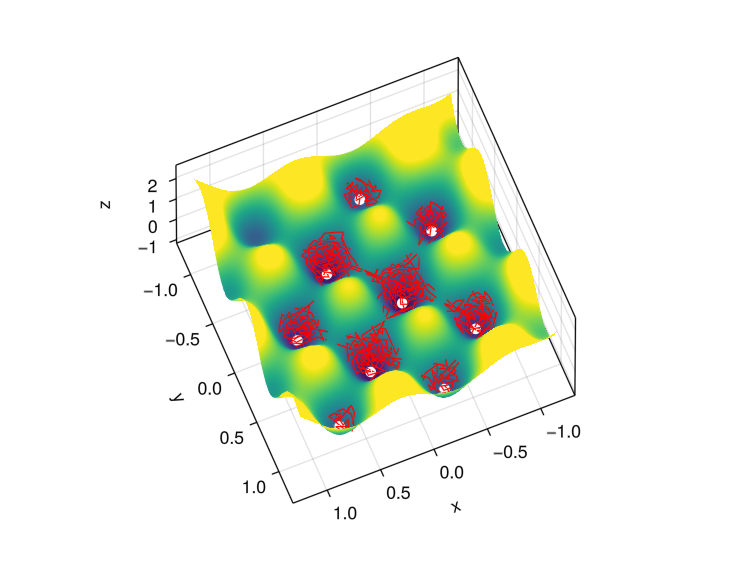

In [9]:
# Plot the PES and explored minima
f = Figure()
ax = Axis3(f[1, 1], azimuth = pi/8*3, elevation = pi/8*3)

surface!(ax, X, Y, Z, colormap = :viridis, shading = NoShading, colorrange = (-1, 1),)
scatter!(ax, basin_list_x, basin_list_y, basin_list_z.+0.1, color = :white, markersize = 12)
lines!(ax, history_x, history_y, (history_z.*0).+0, color = :red, markersize = 0, linewidth = 1)

f

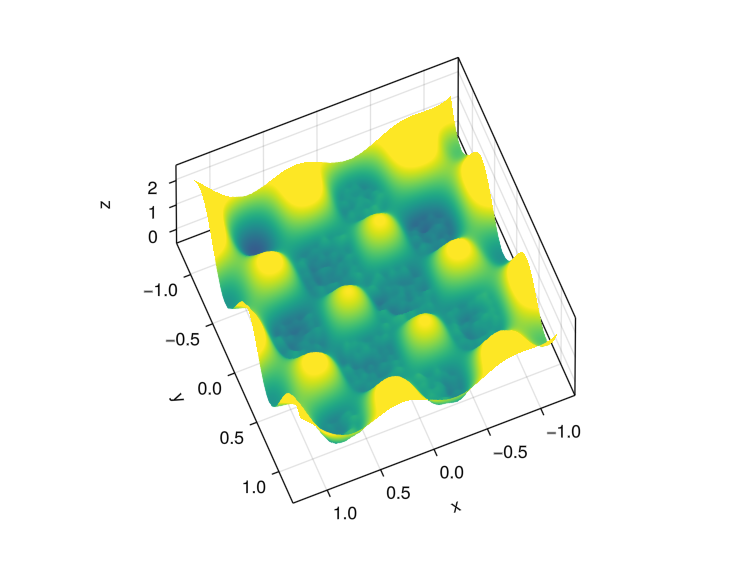

In [10]:
# Plot the PES filed with bias potential
f2 = Figure()
ax = Axis3(f2[1, 1], azimuth = pi/8*3, elevation = pi/8*3)

f_new = x -> f_z(x) + f_basin(x) + f_phi_p(x, x_list, sigma, W) 
# Z_bias = elementwise_f(f_new, X, Y)
Z_bias = map(x->f_new(x), zip(X, Y))

surface!(ax, X, Y, Z_bias, colormap = :viridis, shading = NoShading, colorrange = (-1, 1))

f2

In [11]:
σΓα